In [35]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import countDistinct, count, avg, udf, lit, col, mean, array, log
# from pyspark.sql.functions import count, avg
# from pyspark.sql.functions import udf, lit
from pyspark.sql.types import *
import math
from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
%matplotlib inline

from scipy.misc.pilutil import imread

In [18]:
spark = SparkSession.builder\
    .appName("pubg")\
    .getOrCreate()

In [19]:
directory = "/user/krk386/pubg/deaths/deaths/"
files = ["kill_match_stats_final_0.csv",
         "kill_match_stats_final_1.csv"]
deaths = None
for file in files:
    TempDeaths = spark.read.csv(directory+file,header='true')
    if deaths:
        deaths = deaths.union(TempDeaths)
    else:
        deaths = TempDeaths        

In [20]:
deaths.printSchema()

root
 |-- killed_by: string (nullable = true)
 |-- killer_name: string (nullable = true)
 |-- killer_placement: string (nullable = true)
 |-- killer_position_x: string (nullable = true)
 |-- killer_position_y: string (nullable = true)
 |-- map: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- time: string (nullable = true)
 |-- victim_name: string (nullable = true)
 |-- victim_placement: string (nullable = true)
 |-- victim_position_x: string (nullable = true)
 |-- victim_position_y: string (nullable = true)



In [25]:
agg_directory = "pubg/aggregate/"
agg_files = ["agg_match_stats_0.csv",
         "agg_match_stats_1.csv"]
aggregate = None
for file in agg_files:
    tempAgg = spark.read.csv(agg_directory+file,header='true')
    if aggregate:
        aggregate = aggregate.union(tempAgg)
    else:
        aggregate = tempAgg

In [26]:
aggregate.printSchema()

root
 |-- date: string (nullable = true)
 |-- game_size: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- match_mode: string (nullable = true)
 |-- party_size: string (nullable = true)
 |-- player_assists: string (nullable = true)
 |-- player_dbno: string (nullable = true)
 |-- player_dist_ride: string (nullable = true)
 |-- player_dist_walk: string (nullable = true)
 |-- player_dmg: string (nullable = true)
 |-- player_kills: string (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_survive_time: string (nullable = true)
 |-- team_id: string (nullable = true)
 |-- team_placement: string (nullable = true)



In [21]:
deaths_df = deaths.withColumn("victim_position_x", deaths["victim_position_x"].cast(FloatType()))
deaths_df = deaths_df.withColumn("victim_position_y", deaths_df["victim_position_y"].cast(FloatType()))
deaths_df = deaths_df.withColumn("killer_position_x", deaths_df["killer_position_x"].cast(FloatType()))
deaths_df = deaths_df.withColumn("killer_position_y", deaths_df["killer_position_y"].cast(FloatType()))
deaths_df.printSchema()

root
 |-- killed_by: string (nullable = true)
 |-- killer_name: string (nullable = true)
 |-- killer_placement: string (nullable = true)
 |-- killer_position_x: float (nullable = true)
 |-- killer_position_y: float (nullable = true)
 |-- map: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- time: string (nullable = true)
 |-- victim_name: string (nullable = true)
 |-- victim_placement: string (nullable = true)
 |-- victim_position_x: float (nullable = true)
 |-- victim_position_y: float (nullable = true)



In [27]:
# aggregate4_df = aggregate.filter(aggregate.party_size == "4")
aggregate4_df = aggregate.select("match_id")
size4_matches = aggregate4_df.groupBy("match_id").count()
size4_ids = size4_matches.select("match_id").collect()
size4_ids = [str(Id.match_id) for Id in size4_ids]
print(len(size4_ids))

299984


In [28]:
size4_matches_total = len(size4_ids)
size4_matches_total

299984

In [29]:
def getAverage(total, count):
    return total/count

getAverage_UDF = udf(getAverage, DoubleType()) # StringType())

In [30]:
# deaths_size4 = deaths_df.filter(deaths_df.match_id.isin(size4_ids))
deaths_size4 = deaths_df.select("killed_by")
deaths4_by_cause = deaths_size4.groupBy("killed_by").count() # deaths_size4.groupBy(match_id,killed_by).count()

In [31]:
deaths4_by_cause_average = deaths4_by_cause.withColumn('average', getAverage_UDF(deaths4_by_cause["count"],lit(size4_matches_total)))
# deaths4_by_cause_average = deaths4_by_cause_average.sort(col("average").desc())

In [34]:
deaths4_by_cause_average.write.csv("/user/krk386/pubg/avg_death_cause", header=False)
# deaths4_by_cause_average.show()

In [57]:
death_causes = pd.read_csv('/home/krk386/pubg/data/death_cause.csv', header=None)

In [58]:
death_causes = death_causes.sort_values(by=2, ascending=False)

In [59]:
death_causes = death_causes.head(10)

## Average number of deaths for a given cause in a game

Text(17.2,0.5,'average deaths per game')

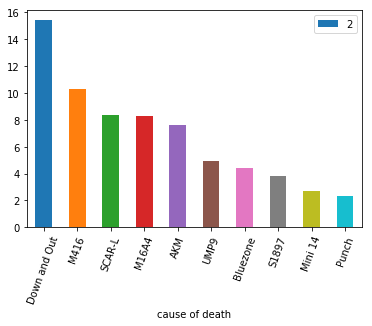

In [75]:
ax = death_causes.plot.bar(x=0, y=2, rot=70)
ax.set_xlabel("cause of death")
plot.set_ylabel("average deaths per game")

# Kills and team placement

In [61]:
kills = aggregate.filter(aggregate.party_size == "4")#kills_quad
kills.head()

Row(date='2017-12-11T22:02:39+0000', game_size='24', match_id='2U4GBNA0YmnmvI29GR080nJ5U4oZyrJ2kJqz7BeQrwDdx68BbncOZ_5DnysRn2Ca', match_mode='tpp', party_size='4', player_assists='3', player_dbno='6', player_dist_ride='6717.846', player_dist_walk='2822.9846199999997', player_dmg='1116', player_kills='9', player_name='Toronto_Edision', player_survive_time='1767.0870000000002', team_id='3', team_placement='1')

In [62]:
# rank_and_kills = kills_solo[['team_placement', 'player_kills']]
# plot = rank_and_kills.plot.scatter(x='team_placement', y='player_kills', color='green')
# plot.set_xlabel("rank")
# plot.set_ylabel("kills")
# plot.grid(color='black', axis=['x', 'y'], linestyle='solid')
rank_and_kills = kills.select("team_placement", "player_kills")
rank_and_kills = rank_and_kills.withColumn("team_placement", rank_and_kills["team_placement"].cast(IntegerType()))
rank_and_kills = rank_and_kills.withColumn("player_kills", rank_and_kills["player_kills"].cast(IntegerType()))

In [63]:
rank_and_kills.printSchema()

root
 |-- team_placement: integer (nullable = true)
 |-- player_kills: integer (nullable = true)



In [64]:
rank_and_kills.write.csv("/user/krk386/pubg/rank_and_kills", header=False)

In [65]:
rank_and_kills_pd = pd.read_csv('/home/krk386/pubg/data/rank_kills.csv', header=None)

In [68]:
rank_and_kills_pd = rank_and_kills_pd.rename(index=str, columns={0: "team_placement", 1: "player_kills"})

## A plot of kills vs rank in a game

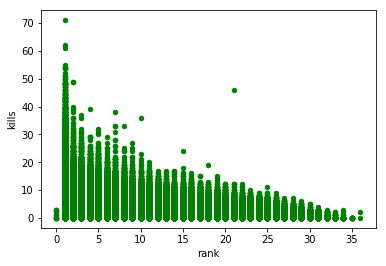

In [71]:
plot = rank_and_kills_pd.plot.scatter(x='team_placement', y='player_kills', color='green')
plot.set_xlabel("rank")
plot.set_ylabel("kills")
plot.grid(color='black', axis=['x', 'y'], linestyle='solid')

## Average rank based on kills

In [72]:
rank_average_kills = rank_and_kills.groupBy("player_kills").agg(mean("team_placement"))
rank_average_kills = rank_average_kills.sort(col("player_kills").desc()) # avg(team_placement)
rank_average_kills.show()

+------------+-------------------+
|player_kills|avg(team_placement)|
+------------+-------------------+
|          71|                1.0|
|          62|                1.0|
|          61|                1.0|
|          55|                1.0|
|          54|                1.0|
|          52|                1.0|
|          51|                1.0|
|          50|                1.0|
|          49|                1.5|
|          48|                1.0|
|          47|                1.0|
|          46|  4.333333333333333|
|          45|                1.0|
|          44|                1.0|
|          43|                1.0|
|          42|                1.0|
|          41|                1.0|
|          40| 1.0769230769230769|
|          39| 1.2666666666666666|
|          38|             1.4375|
+------------+-------------------+
only showing top 20 rows



In [73]:
rank_average_kills.head()

Row(player_kills=71, avg(team_placement)=1.0)

### Winner number of kills

the number of kills show us an interesting pattern for quad and solo teams.
for quad teams the number of winners with zero kills are extremely high. So you can come first without making any kills

In [78]:
winners = rank_and_kills.filter(rank_and_kills.team_placement == 1)
first_place_kills = winners.select('player_kills')
first_place_kills_pd = first_place_kills.toPandas()# rank_and_kills_pd.loc[rank_and_kills_pd['team_placement'] == 1]

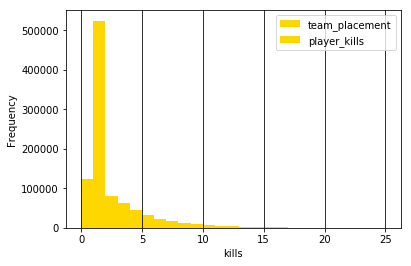

In [79]:
my_hist = first_place_kills_pd.plot.hist(bins=25, range=(0,25), color='gold')
my_hist.set_xlabel("kills")
my_hist.grid(color='black', axis='x', linestyle='solid')

# Kill distance analysis

In [ ]:
# deaths_df.createOrReplaceTempView("deaths") 
# spark.sql("select * from deaths where (victim_position_x != 0 and victim_position_y != 0) and (killer_position_x != 0 and killer_position_y )")

In [80]:
# print(deaths_df.count())
deaths_df_filtered = deaths_df.filter(((deaths_df.victim_position_x != 0) & (deaths_df.victim_position_y != 0)) & \
                    ((deaths_df.killer_position_x != 0) & (deaths_df.killer_position_y != 0)) & (deaths_df.map == "ERANGEL"))
# deaths_df_filtered.count()

In [81]:
def getDistance(positions):
    vx = positions[0]
    vy = positions[1]
    kx = positions[2]
    ky = positions[3]
    return ((vx-kx)**2 + (vy-ky)**2)**(0.5)
getDistance_UDF = udf(getDistance, DoubleType())

In [82]:
# getDistance([1,1,2,2])
deaths_df_filtered = deaths_df_filtered.select("killed_by","victim_position_x","victim_position_y","killer_position_x","killer_position_y")

In [83]:
deaths_df_dist = deaths_df_filtered.withColumn("distance", getDistance_UDF(array("victim_position_x","victim_position_y","killer_position_x","killer_position_y")))
deaths_df_dist = deaths_df_dist.withColumn("log_distance", log("distance"))
# deaths_df_dist.count()

In [85]:
# deaths_df_dist.where(deaths_df_dist.killed_by == "Punch").sort(col("distance")).show()
# deaths_df_dist.printSchema()
weapon_avg_distance = deaths_df_dist.groupBy("killed_by").mean("distance") #.agg(mean("distance")) # .agg(mean("log_distance"))
weapon_avg_distance.printSchema()

root
 |-- killed_by: string (nullable = true)
 |-- avg(distance): double (nullable = true)



In [86]:
# deaths_df_dist.where(deaths_df_dist.killed_by == "Punch").sort(col("distance")).show()
# deaths_df_dist.printSchema()
weapon_avg_distance = deaths_df_dist.groupBy("killed_by").mean("distance") #.agg(mean("distance")) # .agg(mean("log_distance"))
# weapon_avg_distance.printSchema()
weapon_avg_distance = weapon_avg_distance.sort(col("avg(distance)")) # .sort(col("avg(log_distance)").desc())
# weapon_avg_distance.show()

In [87]:
kill_distance_pd = weapon_avg_distance.toPandas()

In [91]:
kill_distance_pd = kill_distance_pd.tail(10)

## The average kill distance for a given weapon

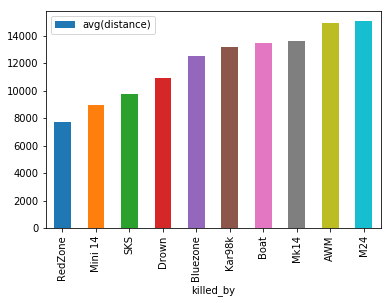

In [92]:
dist_plot = kill_distance_pd.plot.bar(x='killed_by', y='avg(distance)', rot=90)
my_hist.set_xlabel("kills")
my_hist.grid(color='black', axis='x', linestyle='solid')